In [230]:
# GPU로 Tesla T4가 준비돼있습니다.
!nvidia-smi

Wed Jun 26 04:41:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    26W /  70W |    945MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [342]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
# import wandb
# from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
import numpy as np
from konlpy.tag import Mecab, Okt, Hannanum, Kkma # 한국어 토크나이저
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. 데이터 가져오기

In [343]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()
train_data = train_data[['conversation','class']]
train_data.head()

,conversation,class
0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,협박 대화
1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,협박 대화
2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,기타 괴롭힘 대화
3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,갈취 대화
4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,갈취 대화


### 2. 데이터 전처리

#### 2-1. 결측치, 중복처리

In [344]:
train_data.isna().sum()

conversation    0
class           0
dtype: int64

In [345]:
train_data.shape[0], train_data['conversation'].nunique()

(3950, 3846)

In [346]:
train_data = train_data.drop_duplicates(['conversation'])
train_data.shape[0]

3846

#### 2-2.레이블 인코딩

In [347]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)
print(encoder.classes_)
# '갈취 대화' -> 0
# '기타 괴롭힘 대화' -> 1
# '직장 내 괴롭힘 대화' -> 2
# '협박 대화' -> 3

['갈취 대화' '기타 괴롭힘 대화' '직장 내 괴롭힘 대화' '협박 대화']


In [348]:
train_data['class'] = encoder.transform(train_data['class'])

corpus = train_data["conversation"]

train_data

,conversation,class
0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,3
1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,3
2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,1
3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,0
4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0
...,...,...
3945,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,1
3946,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,0
3947,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,2
3948,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,0


#### 2-3. 단어 사전용 전처리

In [349]:
train_data['document'] = train_data['conversation'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
train_data['document'] = train_data['conversation'].str.replace('^ +', "") # 공백은 empty 값으로 변경
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 샘플의 개수 :',len(train_data))

전처리 후 샘플의 개수 : 3846


/tmp/ipykernel_60/1142125926.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['conversation'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_60/1142125926.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['conversation'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [350]:
# 불용어 목록
stopwords = """
아
휴
아이구
아이쿠
아이고
어
나
우리
저희
따라
의해
을
를
에
의
가
으로
로
에게
뿐이다
의거하여
근거하여
입각하여
기준으로
예하면
예를 들면
예를 들자면
저
소인
소생
저희
지말고
하지마
하지마라
다른
물론
또한
그리고
비길수 없다
해서는 안된다
뿐만 아니라
만이 아니다
만은 아니다
막론하고
관계없이
그치지 않다
그러나
그런데
하지만
든간에
논하지 않다
따지지 않다
설사
비록
더라도
아니면
만 못하다
하는 편이 낫다
불문하고
향하여
향해서
향하다
쪽으로
틈타
이용하여
타다
오르다
제외하고
이 외에
이 밖에
하여야
비로소
한다면 몰라도
외에도
이곳
여기
부터
기점으로
따라서
할 생각이다
하려고하다
이리하여
그리하여
그렇게 함으로써
하지만
일때
할때
앞에서
중에서
보는데서
으로써
로써
까지
해야한다
일것이다
반드시
할줄알다
할수있다
할수있어
임에 틀림없다
한다면
등
등등
제
겨우
단지
다만
할뿐
딩동
댕그
대해서
대하여
대하면
훨씬
얼마나
얼마만큼
얼마큼
남짓
여
얼마간
약간
다소
좀
조금
다수
몇
얼마
지만
하물며
또한
그러나
그렇지만
하지만
이외에도
대해 말하자면
뿐이다
다음에
반대로
반대로 말하자면
이와 반대로
바꾸어서 말하면
바꾸어서 한다면
만약
그렇지않으면
까악
툭
딱
삐걱거리다
보드득
비걱거리다
꽈당
응당
해야한다
에 가서
각
각각
여러분
각종
각자
제각기
하도록하다
와
과
그러므로
그래서
고로
한 까닭에
하기 때문에
거니와
이지만
대하여
관하여
관한
과연
실로
아니나다를가
생각한대로
진짜로
한적이있다
하곤하였다
하
하하
허허
아하
거바
와
오
왜
어째서
무엇때문에
어찌
하겠는가
무슨
어디
어느곳
더군다나
하물며
더욱이는
어느때
언제
야
이봐
어이
여보시오
흐흐
흥
휴
헉헉
헐떡헐떡
영차
여차
어기여차
끙끙
아야
앗
아야
콸콸
졸졸
좍좍
뚝뚝
주룩주룩
솨
우르르
그래도
또
그리고
바꾸어말하면
바꾸어말하자면
혹은
혹시
답다
및
그에 따르는
때가 되어
즉
지든지
설령
가령
하더라도
할지라도
일지라도
지든지
몇
거의
하마터면
인젠
이젠
된바에야
된이상
만큼	어찌됏든
그위에
게다가
점에서 보아
비추어 보아
고려하면
하게될것이다
일것이다
비교적
좀
보다더
비하면
시키다
하게하다
할만하다
의해서
연이서
이어서
잇따라
뒤따라
뒤이어
결국
의지하여
기대여
통하여
자마자
더욱더
불구하고
얼마든지
마음대로
주저하지 않고
곧
즉시
바로
당장
하자마자
밖에 안된다
하면된다
그래
그렇지
요컨대
다시 말하자면
바꿔 말하면
즉
구체적으로
말하자면
시작하여
시초에
이상
허
헉
허걱
바와같이
해도좋다
해도된다
게다가
더구나
하물며
와르르
팍
퍽
펄렁
동안
이래
하고있었다
이었다
에서
로부터
까지
예하면
했어요
해요
함께
같이
더불어
마저
마저도
양자
모두
습니다
가까스로
하려고하다
즈음하여
다른
다른 방면으로
해봐요
습니까
했어요
말할것도 없고
무릎쓰고
개의치않고
하는것만 못하다
하는것이 낫다
매
매번
들
모
어느것
어느
로써
갖고말하자면
어디
어느쪽
어느것
어느해
어느 년도
라 해도
언젠가
어떤것
어느것
저기
저쪽
저것
그때
그럼
그러면
요만한걸
그래
그때
저것만큼
그저
이르기까지
할 줄 안다
할 힘이 있다
너
너희
당신
어찌
설마
차라리
할지언정
할지라도
할망정
할지언정
구토하다
게우다
토하다
메쓰겁다
옆사람
퉤
쳇
의거하여
근거하여
의해
따라
힘입어
그
다음
버금
두번째로
기타
첫번째로
나머지는
그중에서
견지에서
형식으로 쓰여
입장에서
위해서
단지
의해되다
하도록시키다
뿐만아니라
반대로
전후
전자
앞의것
잠시
잠깐
하면서
그렇지만
다음에
그러한즉
그런즉
남들
아무거나
어찌하든지
같다
비슷하다
예컨대
이럴정도로
어떻게
만약
만일
위에서 서술한바와같이
인 듯하다
하지 않는다면
만약에
무엇
무슨
어느
어떤
아래윗
조차
한데
그럼에도 불구하고
여전히
심지어
까지도
조차도
하지 않도록
않기 위하여
때
시각
무렵
시간
동안
어때
어떠한
하여금
네
예
우선
누구
누가 알겠는가
아무도
줄은모른다
줄은 몰랏다
하는 김에
겸사겸사
하는바
그런 까닭에
한 이유는
그러니
그러니까
때문에
그
너희
그들
너희들
타인
것
것들
너
위하여
공동으로
동시에
하기 위하여
어찌하여
무엇때문에
붕붕
윙윙
나
우리
엉엉
휘익
윙윙
오호
아하
어쨋든
만 못하다	하기보다는
차라리
하는 편이 낫다
흐흐
놀라다
상대적으로 말하자면
마치
아니라면
쉿
그렇지 않으면
그렇지 않다면
안 그러면
아니었다면
하든지
아니면
이라면
좋아
알았어
하는것도
그만이다
어쩔수 없다
하나
일
일반적으로
일단
한켠으로는
오자마자
이렇게되면
이와같다면
전부
한마디
한항목
근거로
하기에
아울러
하지 않도록
않기 위해서
이르기까지
이 되다
로 인하여
까닭으로
이유만으로
이로 인하여
그래서
이 때문에
그러므로
그런 까닭에
알 수 있다
결론을 낼 수 있다
으로 인하여
있다
어떤것
관계가 있다
관련이 있다
연관되다
어떤것들
에 대해
이리하여
그리하여
여부
하기보다는
하느니
하면 할수록
운운
이러이러하다
하구나
하도다
다시말하면
다음으로
에 있다
에 달려 있다
우리
우리들
오히려
하기는한데
어떻게
어떻해
어찌됏어
어때
어째서
본대로
자
이
이쪽
여기
이것
이번
이렇게말하자면
이런
이러한
이와 같은
요만큼
요만한 것
얼마 안 되는 것
이만큼
이 정도의
이렇게 많은 것
이와 같다
이때
이렇구나
것과 같이
끼익
삐걱
따위
와 같은 사람들
부류의 사람들
왜냐하면
중의하나
오직
오로지
에 한하다
하기만 하면
도착하다
까지 미치다
도달하다
정도에 이르다
할 지경이다
결과에 이르다
관해서는
여러분
하고 있다
한 후
혼자
자기
자기집
자신
우에 종합한것과같이
총적으로 보면
총적으로 말하면
총적으로
대로 하다
으로서
참
그만이다
할 따름이다
쿵
탕탕
쾅쾅
둥둥
봐
봐라
아이야
아니
와아
응
아이
참나
년
월
일
령
영
일
이
삼
사
오
육
륙
칠
팔
구
이천육
이천칠
이천팔
이천구
하나
둘
셋
넷
다섯
여섯
일곱
여덟
아홉
령
영
내가
진짜
"""

# 문자열을 리스트로 변환
stopwords_list = stopwords.strip().split('\n')

#### 형태소 분석기 예제

In [351]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [352]:
mecab = Mecab()
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와',
 '이런',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만드',
 '는',
 '게',
 '나을',
 '뻔']

In [353]:
hannanum = Hannanum()
hannanum.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['오',
 '아',
 '이런',
 '것',
 '도',
 '영화',
 '이',
 '라',
 '고',
 '차라리',
 '뮤직비디오',
 '를',
 '만들',
 '는',
 '것',
 '이',
 '나',
 'ㄹ',
 '뻔']

In [354]:
kkma = Kkma()
kkma.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['오',
 '아',
 '이렇',
 'ㄴ',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만들',
 '는',
 '것',
 '이',
 '낫',
 '을',
 '뻔']

#### 2-4. 형태소 분석기 적용

In [355]:
mecab = Mecab()
okt = Okt()
hannanum = Hannanum()
kkma = Kkma()

corpus1 = []
for sentence in tqdm(corpus):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_list] # 불용어 제거
    corpus1.append(stopwords_removed_sentence)

corpus2 = []
for sentence in tqdm(corpus):
    tokenized_sentence = okt.morphs(sentence,stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_list] # 불용어 제거
    corpus2.append(stopwords_removed_sentence)
    
corpus3 = []
for sentence in tqdm(corpus):
    tokenized_sentence = hannanum.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_list] # 불용어 제거
    corpus3.append(stopwords_removed_sentence)
    
corpus4 = []
for sentence in tqdm(corpus):
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords_list] # 불용어 제거
    corpus4.append(stopwords_removed_sentence)
    
corpus5 = []
for sentence in tqdm(corpus):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence] # 불용어 포함
    corpus5.append(stopwords_removed_sentence)

100%|██████████| 3846/3846 [00:02<00:00, 1681.10it/s]


In [356]:
runtime_excl_stopwords = {'mecab_excl':'00:05',
                          'okt_stem_excl':'01:02',
                          'hannanum_excl':'01:11',
                          'kkma_excl':'12:42',
                          'mecab_incl':'00:02'}
print('runtime_excl_stopwords',"-"*50,sep='\n')
for key,index in runtime_excl_stopwords.items():
    print(key,":", index)

runtime_excl_stopwords
--------------------------------------------------
mecab_excl : 00:05
okt_stem_excl : 01:02
hannanum_excl : 01:11
kkma_excl : 12:42
mecab_incl : 00:02


#### 2-5. 정수인코딩 및 단어사전 생성

In [357]:
# corpus1: mecab 불용어 제거
# corpus2: okt 불용어 제거
# corpus3: hannanum 불용어 제거
# corpus4: kkma 불용어 제거
# corpus5: mecab 불용어 포함

###################################
corpus = corpus5
###################################

vocab_size = 1000
tokenizer = Tokenizer(
                    num_words= vocab_size,
                    filters=' ',
                    oov_token="<unk>")
tokenizer.fit_on_texts(corpus)
corpus_sequence = tokenizer.texts_to_sequences(corpus)
padded_corpus_sequence = pad_sequences(corpus_sequence, padding='post',maxlen=20)

In [358]:
print(padded_corpus_sequence.shape, train_data['class'].shape, sep='\n')

(3846, 20)
(3846,)


In [391]:
# 토크나이저를 체크합니다.
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 15: break

1 : <unk>
2 : .
3 : ?
4 : 가
5 : 이
6 : 하
7 : 는
8 : 야
9 : 고
10 : 어
11 : 거
12 : 지
13 : 나
14 : 네
15 : 아


In [360]:
X_train = padded_corpus_sequence[:3300]
y_train = train_data['class'][:3300]
X_val = padded_corpus_sequence[3300:3550]
y_val = train_data['class'][3300:3550]
X_test = padded_corpus_sequence[3550:]
y_test = train_data['class'][3550:]

In [361]:
38

38

### 3. 모델생성
* baseline 모델은 바닐라 RNN 모델로 설정

#### 3-1. 모델실행

In [365]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN, Dropout, Dense

vocab_size = 1000  # 어휘 사전의 크기
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_length=None))
model.add(SimpleRNN(256)) 
model.add(Dropout(0.2)) 
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 20)          20000     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 256)               70912     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 516       
Total params: 124,324
Trainable params: 124,324
Non-trainable params: 0
_________________________________________________________________


In [366]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [367]:
#모델 compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [368]:
#콜백함수
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

callback_list = [
EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료 여부 판단
    patience=10,         # 검증 손실이 개선되지 않는 epoch를 5회까지 허용
    restore_best_weights=True  # 가장 좋은 검증 손실을 낸 모델의 가중치 복원
)
]    

In [369]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/20
104/104 [==============================] - 3s 22ms/step - loss: 1.3871 - accuracy: 0.2764 - val_loss: 1.3092 - val_accuracy: 0.3720
Epoch 2/20
104/104 [==============================] - 2s 21ms/step - loss: 1.2491 - accuracy: 0.4382 - val_loss: 1.2270 - val_accuracy: 0.4280
Epoch 3/20
104/104 [==============================] - 2s 22ms/step - loss: 1.0572 - accuracy: 0.5315 - val_loss: 1.1090 - val_accuracy: 0.4880
Epoch 4/20
104/104 [==============================] - 2s 21ms/step - loss: 0.9024 - accuracy: 0.6200 - val_loss: 1.1040 - val_accuracy: 0.5120
Epoch 5/20
104/104 [==============================] - 2s 22ms/step - loss: 0.7999 - accuracy: 0.6739 - val_loss: 1.1919 - val_accuracy: 0.4640
Epoch 6/20
104/104 [==============================] - 2s 21ms/step - loss: 0.7424 - accuracy: 0.7048 - val_loss: 1.2309 - val_accuracy: 0.5200
Epoch 7/20
104/104 [==============================] - 2s 21ms/step - loss: 0.6272 - accuracy: 0.7630 - val_loss: 1.3791 - val_accuracy: 0.4400

#### 3-2. 모델실행 시각화

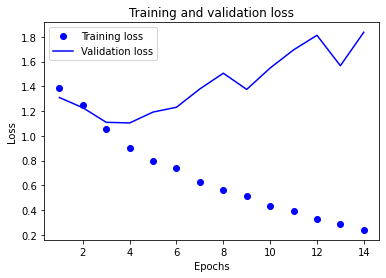

In [370]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

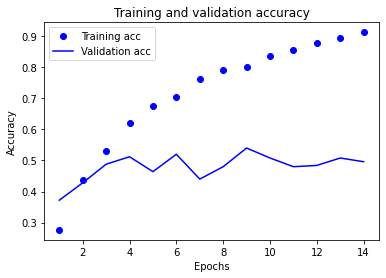

In [371]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 3-3. 성능확인

In [372]:
results = model.evaluate(X_test,  y_test, verbose=2)
y_test

10/10 - 0s - loss: 1.1264 - accuracy: 0.5372


3642    2
3643    3
3644    3
3645    1
3646    3
       ..
3945    1
3946    0
3947    2
3948    0
3949    2
Name: class, Length: 296, dtype: int64

In [373]:
# 예측
y_pred = model.predict(X_test)
y_pred

array([[0.00721398, 0.03332841, 0.93603677, 0.02342085],
       [0.27274412, 0.2449668 , 0.06451453, 0.4177746 ],
       [0.1562914 , 0.39638996, 0.00434885, 0.44296977],
       ...,
       [0.01227908, 0.23567398, 0.71688163, 0.03516531],
       [0.18987235, 0.2003775 , 0.16750696, 0.44224316],
       [0.03680602, 0.5230328 , 0.3091284 , 0.1310328 ]], dtype=float32)

In [374]:
y_pred_classes = y_pred.argmax(axis=-1)  # 예측 확률 값을 클래스 레이블로 변환

In [375]:
y_pred_classes

array([2, 3, 3, 2, 3, 0, 0, 2, 1, 2, 3, 2, 2, 2, 1, 0, 2, 1, 2, 3, 1, 1,
       1, 0, 1, 0, 1, 3, 2, 2, 0, 3, 2, 2, 0, 2, 1, 0, 2, 1, 2, 3, 1, 3,
       0, 0, 1, 1, 1, 3, 3, 3, 2, 1, 0, 2, 2, 2, 3, 0, 0, 2, 2, 2, 0, 1,
       0, 2, 3, 0, 0, 0, 0, 3, 0, 3, 2, 0, 3, 2, 0, 0, 0, 2, 0, 2, 2, 1,
       0, 1, 2, 2, 0, 2, 2, 2, 3, 2, 3, 1, 2, 0, 2, 2, 0, 0, 1, 0, 3, 2,
       0, 0, 2, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 3, 1, 0, 2, 1,
       0, 2, 0, 3, 2, 1, 2, 1, 1, 0, 1, 3, 2, 1, 0, 0, 2, 2, 0, 1, 1, 1,
       0, 0, 3, 0, 2, 2, 2, 3, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 0,
       2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 2, 0, 1, 3, 2, 2, 1, 1, 1,
       2, 2, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 3,
       0, 0, 0, 2, 2, 2, 1, 0, 2, 3, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0,
       0, 2, 0, 1, 0, 2, 1, 2, 2, 0, 0, 3, 3, 0, 1, 2, 1, 0, 0, 0, 2, 3,
       3, 2, 0, 1, 0, 1, 0, 3, 0, 0, 1, 3, 2, 3, 2, 1, 0, 2, 0, 2, 0, 2,
       3, 0, 0, 0, 0, 1, 0, 2, 3, 1])

In [376]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred_classes, output_dict=True)

print(report_dict)

{'0': {'precision': 0.5384615384615384, 'recall': 0.6049382716049383, 'f1-score': 0.5697674418604651, 'support': 81}, '1': {'precision': 0.4393939393939394, 'recall': 0.43283582089552236, 'f1-score': 0.43609022556390975, 'support': 67}, '2': {'precision': 0.5980392156862745, 'recall': 0.7721518987341772, 'f1-score': 0.6740331491712707, 'support': 79}, '3': {'precision': 0.5405405405405406, 'recall': 0.2898550724637681, 'f1-score': 0.37735849056603776, 'support': 69}, 'accuracy': 0.5371621621621622, 'macro avg': {'precision': 0.5291088085205733, 'recall': 0.5249452659246014, 'f1-score': 0.5143123267904208, 'support': 296}, 'weighted avg': {'precision': 0.5324228847678768, 'recall': 0.5371621621621622, 'f1-score': 0.5224850085711711, 'support': 296}}


In [377]:
df = pd.DataFrame(report_dict)
df

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.538462,0.439394,0.598039,0.540541,0.537162,0.529109,0.532423
recall,0.604938,0.432836,0.772152,0.289855,0.537162,0.524945,0.537162
f1-score,0.569767,0.436090,0.674033,0.377358,0.537162,0.514312,0.522485
support,81.000000,67.000000,79.000000,69.000000,0.537162,296.000000,296.000000


#### 3-4. 형태소분석기별 결과 저장(해당 corpus로 이름변경 필요)

In [378]:
df.to_csv('mecab_incl_stopwords.csv', index=True,index_label=False)

#### 3-5. 형태소분석기별 저장된 결과 불러오기

In [381]:
# mecab excluding stopwords
pd.read_csv('mecab_excl_stopwords.csv')

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.718750,0.421053,0.712121,0.450704,0.557432,0.575657,0.587113
recall,0.567901,0.597015,0.594937,0.463768,0.557432,0.555905,0.557432
f1-score,0.634483,0.493827,0.648276,0.457143,0.557432,0.558432,0.564987
support,81.000000,67.000000,79.000000,69.000000,0.557432,296.000000,296.000000


In [382]:
# mecab including stopwords
pd.read_csv('mecab_incl_stopwords.csv')

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.538462,0.439394,0.598039,0.540541,0.537162,0.529109,0.532423
recall,0.604938,0.432836,0.772152,0.289855,0.537162,0.524945,0.537162
f1-score,0.569767,0.436090,0.674033,0.377358,0.537162,0.514312,0.522485
support,81.000000,67.000000,79.000000,69.000000,0.537162,296.000000,296.000000


In [383]:
# okt excluding stopwords
pd.read_csv('okt_excl_stopwords.csv')

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.500000,0.376471,0.730769,0.438596,0.493243,0.511459,0.519316
recall,0.629630,0.477612,0.481013,0.362319,0.493243,0.487643,0.493243
f1-score,0.557377,0.421053,0.580153,0.396825,0.493243,0.488852,0.495173
support,81.000000,67.000000,79.000000,69.000000,0.493243,296.000000,296.000000


In [384]:
# hannanum excluding stopwords
pd.read_csv('hannanum_excl_stopwords.csv')

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.434783,0.364583,0.633333,0.390244,0.466216,0.455736,0.461502
recall,0.370370,0.522388,0.721519,0.231884,0.466216,0.461540,0.466216
f1-score,0.400000,0.429448,0.674556,0.290909,0.466216,0.448728,0.454512
support,81.000000,67.000000,79.000000,69.000000,0.466216,296.000000,296.000000


In [385]:
# kkma excluding stopwords
pd.read_csv('kkma_excl_stopwords.csv')

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.628571,0.366667,0.594937,0.491228,0.513514,0.520351,0.528296
recall,0.543210,0.492537,0.594937,0.405797,0.513514,0.509120,0.513514
f1-score,0.582781,0.420382,0.594937,0.444444,0.513514,0.510636,0.517019
support,81.000000,67.000000,79.000000,69.000000,0.513514,296.000000,296.000000
